## Data Cleaning

After peaking and searching through the data, web urls, NEWLINE_TOKEN, TAB_TOKEN and unmeaningful puncutations were found. Below is the helper function that cleans the comments. In addition, digits are also removed since numbers can seldom be used to express personal attack.

All the examinations on the data were utilized to clean the data throughout the entire process including the final best model.

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

In [1]:
import string
import re
def clean(raw):
    # Remove newline and tab tokens
    no_newline = raw.replace("NEWLINE_TOKEN", "")
    no_tab = no_newline.replace("TAB_TOKEN", "")
    # Remove web urls
    no_url = re.sub(r"((www\S+)|(http\S+))", "", no_tab)
    # To lowercase
    lower = no_url.lower()
    # Remove punctuations and replace with space
    no_punc = re.sub(f"[{re.escape(string.punctuation)}]", " ", lower)
    # Remove digits
    no_digit = re.sub(r"\d", " ", no_punc)
    # Merge multiple spaces into one space
    merge_space = re.sub(r"\s+", " ", no_digit)

    return merge_space

#### Organize data into pandas

In [2]:
import pandas as pd
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

#### Merge these two data structures into one

In [3]:
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5
comments['attack'] = labels

#### Clean comments

In [4]:
comments['comment'] = comments['comment'].apply(clean)
comments.query('attack')['comment'].head()

rev_id
801279                          iraq is not good usa is bad 
2702703     fuck off you little asshole if you want to ta...
4632658           i have a dick its bigger than yours hahaha
6545332     renault you sad little bpy for driving a rena...
6545351     renault you sad little bo for driving a renau...
Name: comment, dtype: object

## Visualization

_Below data is obtained by writing the merged data into another csv file and plotting using excel_

1. The percentage of attack comments by year

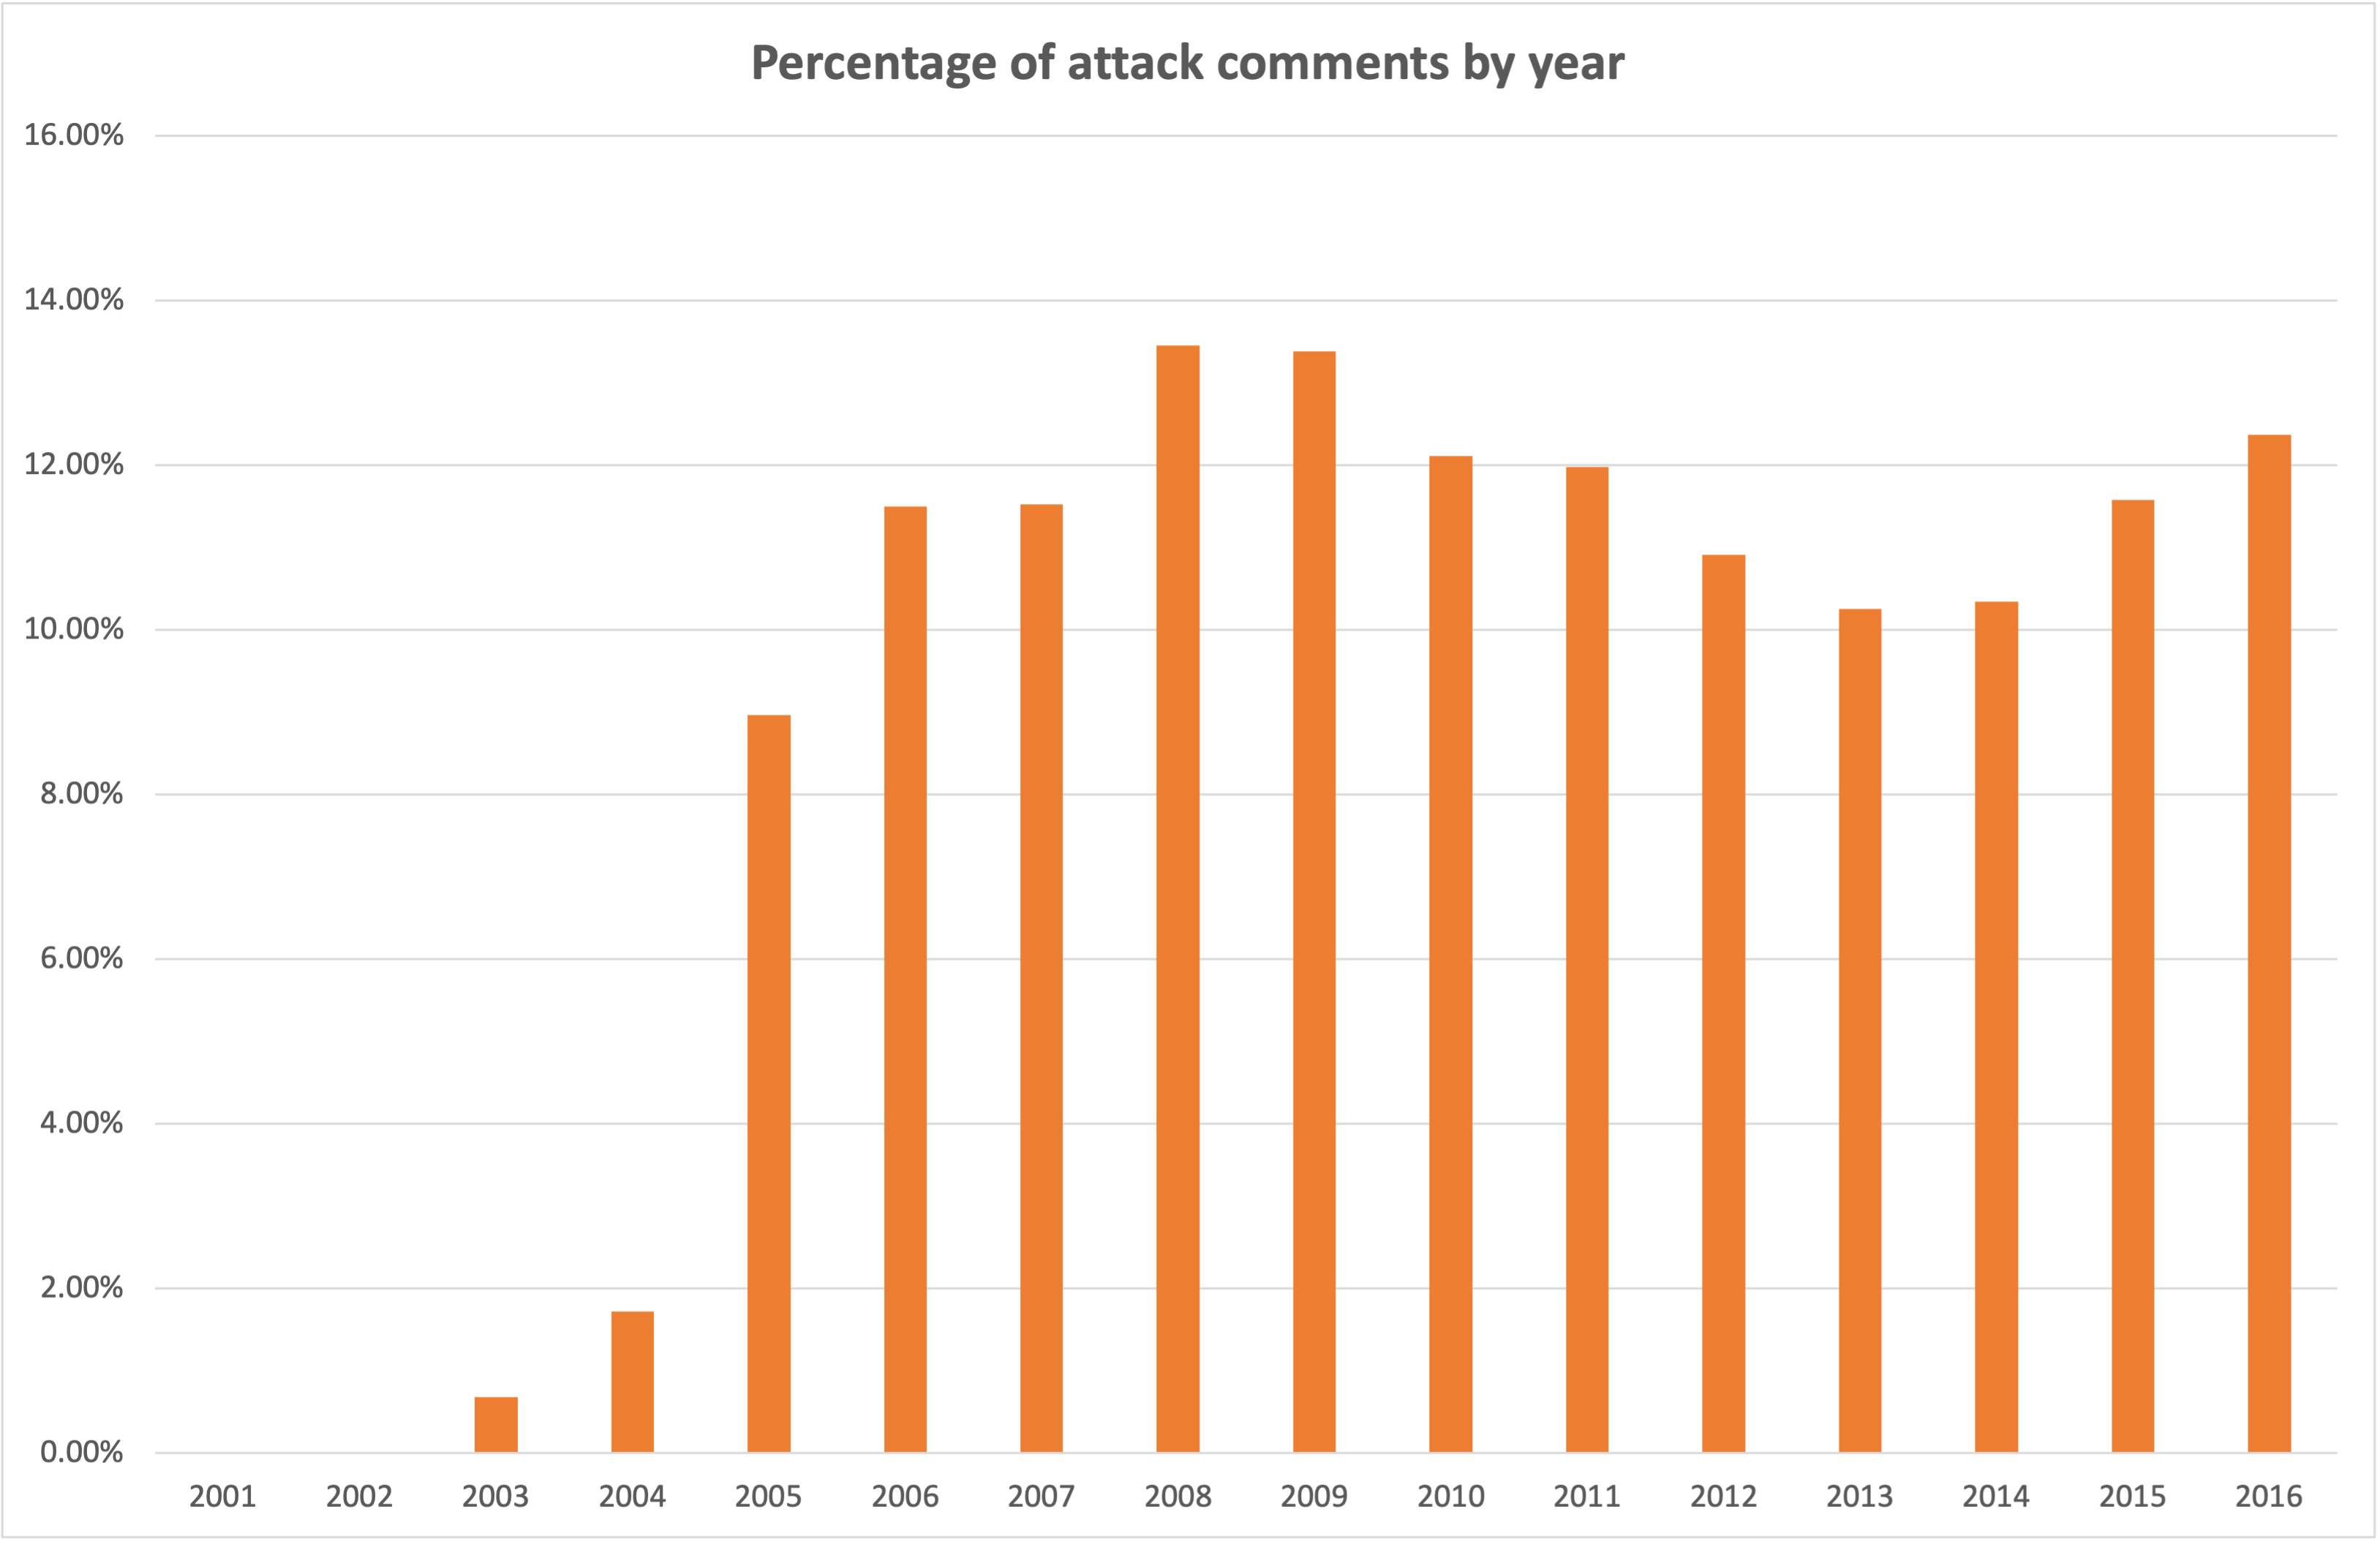

2. The percentage of attact comments by namespace

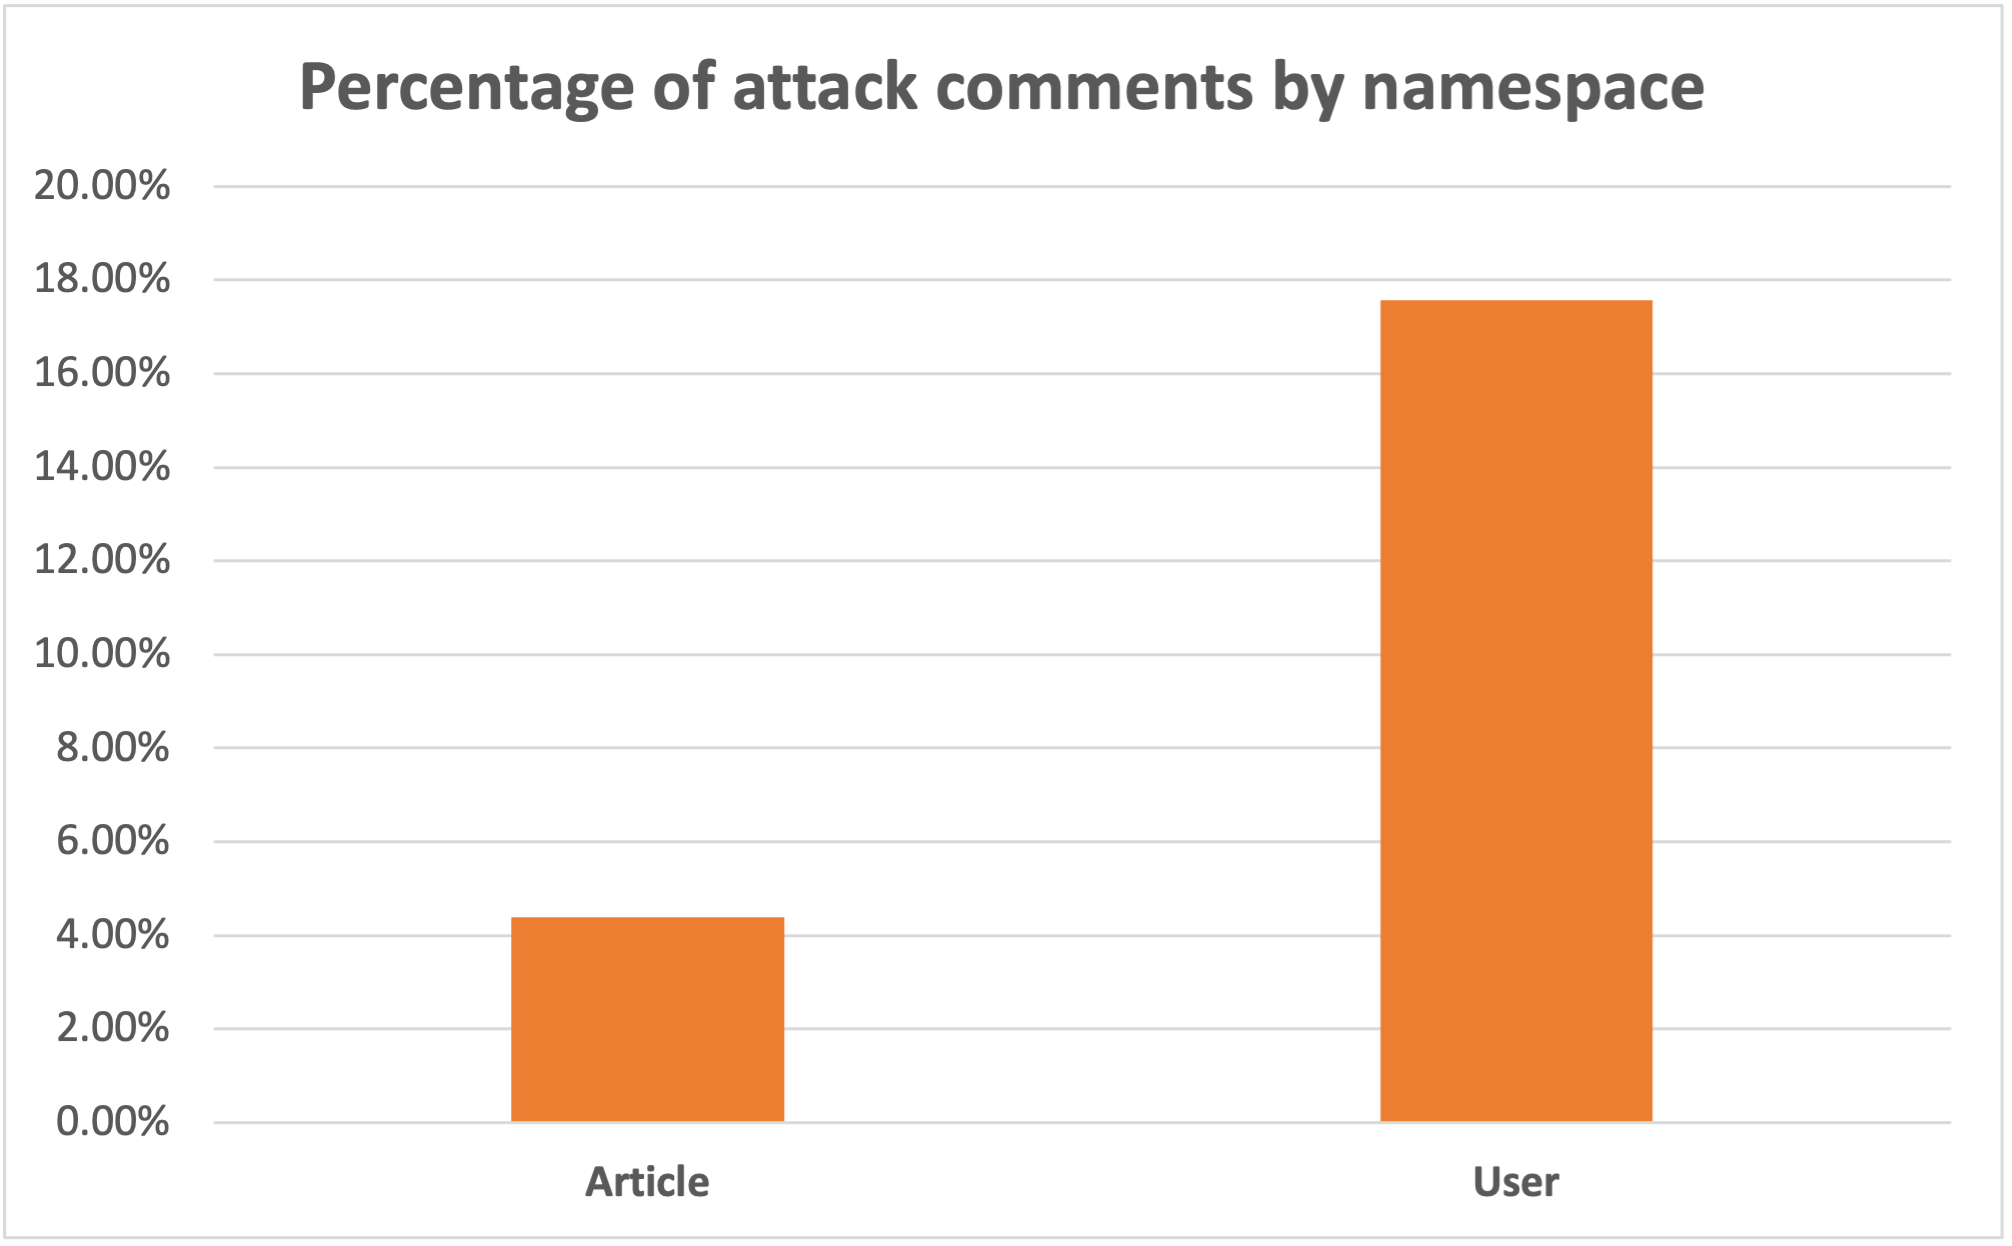

According to below tables, it's quite easy to draw the conclusion that __Users give more attack comments than Articles__(Table 1), given that the number of samples from these two categories are close. On the other hand, it might not be fair to say that __People are more angry in 2006 than they are in 2002__ because of the inbalanced sample collected in each year(Table 2).

__Table 1:__
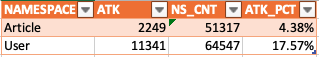

__Table 2:__
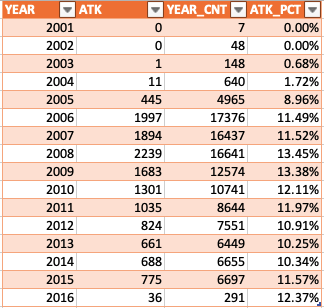

## Training

#### KFold cross-validation (K = 5)
1. Merge train and test data. 
2. I assigned k with the value 5 here, because it's a normally used k-value plus the batch size after spliting into 5 will be 23172, which is closer to the size of the test sample than other common k-values.

Helper function to evaluate the model and format classification report together with confusion matrix

In [111]:
def KFold_eval(clf):
    train_pred = cross_val_predict(clf, comments['comment'], comments['attack'], cv=5)
    
    print('===Classification Report===')
    print(classification_report(comments['attack'], train_pred))
    
    tn, fp, fn, tp = confusion_matrix(comments['attack'], train_pred).ravel()
    print('===Confusion Matrix===')
    print(f'True Positive: {tp}\tFalse Positive: {fp}')
    print(f'False Negative: {fn}\tTrue Negative: {tn}')

#### DecisionTreeClassifier with cleaned data

In [112]:
clf = Pipeline([    
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', DecisionTreeClassifier(random_state = 123)),
])

KFold_eval(clf)

===Classification Report===
              precision    recall  f1-score   support

       False       0.95      0.95      0.95    102274
        True       0.64      0.62      0.63     13590

    accuracy                           0.91    115864
   macro avg       0.79      0.79      0.79    115864
weighted avg       0.91      0.91      0.91    115864

===Confusion Matrix===
True Positive: 8415	False Positive: 4836
False Negative: 5175	True Negative: 97438


_However, the data for attack / non-attack comments is very imbalanced_

#### Now re-sample imbalanced data

In [113]:
# Peak data
comments['attack'].value_counts()

False    102274
True      13590
Name: attack, dtype: int64

Remove random non-attack samples to make the dataset with a size of __110k__

In [114]:
# Drop non-attack data randomly so that we keep 55000 of non-attack comments
train_data_reduced = comments.drop(comments[comments['attack'] == False].sample(102274-55000).index)
train_data_reduced['attack'].value_counts()

False    55000
True     13590
Name: attack, dtype: int64

Match attack comments' size to that of non-attack comments

In [115]:
train_comments = train_data_reduced['comment'].ravel()

In [116]:
max_feature = 10000
train_one_hot = [one_hot(d, max_feature) for d in train_comments]

__Comment length information:__

Average word counts per sample: 69.65

Median word counts: 35

Maximum word counts among all sample: 2831


Therefore, a length of 300 should be sufficient to cover the majority of comments

In [117]:
# Cut document after 300 words
max_len = 300
train_one_hot = pad_sequences(train_one_hot, maxlen=max_len, padding='post')

Use SMOTE to resample the minority of data (attack comments)

In [118]:
smt = SMOTE(sampling_strategy='minority', random_state=10)
train_balanced, train_label_balanced = smt.fit_resample(train_one_hot, train_data_reduced['attack'])

In [119]:
train_balanced.shape

(110000, 300)

In [120]:
train_label_balanced.shape

(110000,)

__Now we have balanced data__

In [122]:
pd.DataFrame(train_label_balanced)['attack'].value_counts()

False    55000
True     55000
Name: attack, dtype: int64

In [123]:
# Improve KFold evaluation helper function by customizing the training data and labels
def KFold_eval_improved(clf, X, y, k):
    train_pred = cross_val_predict(clf, X, y, cv=k)
    
    print('===\tClassification Report\t===')
    print(classification_report(y, train_pred))
    
    tn, fp, fn, tp = confusion_matrix(y, train_pred).ravel()
    print('===\tConfusion Matrix\t===')
    print(f'True Positive: {tp}\tFalse Positive: {fp}')
    print(f'False Negative: {fn}\tTrue Negative: {tn}')

#### DecisionTreeClassifier with balanced dataset

In [124]:
# Drpping the CountVectorizer because the data is already vectorized
clf = Pipeline([
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', DecisionTreeClassifier(random_state = 123)),
])

In [125]:
KFold_eval_improved(clf, train_balanced, train_label_balanced, 5)

===	Classification Report	===
              precision    recall  f1-score   support

       False       0.73      0.67      0.70     55000
        True       0.70      0.75      0.72     55000

    accuracy                           0.71    110000
   macro avg       0.71      0.71      0.71    110000
weighted avg       0.71      0.71      0.71    110000

===	Confusion Matrix	===
True Positive: 41316	False Positive: 18079
False Negative: 13684	True Negative: 36921


#### MultinomialNB with balanced dataset

In [126]:
from sklearn.naive_bayes import MultinomialNB
clf = Pipeline([
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('mnb', MultinomialNB()),
])

KFold_eval_improved(clf, train_balanced, train_label_balanced, 5)

===	Classification Report	===
              precision    recall  f1-score   support

       False       0.61      0.41      0.49     55000
        True       0.56      0.73      0.63     55000

    accuracy                           0.57    110000
   macro avg       0.58      0.57      0.56    110000
weighted avg       0.58      0.57      0.56    110000

===	Confusion Matrix	===
True Positive: 40242	False Positive: 32264
False Negative: 14758	True Negative: 22736


Slight improvements after changing K value to 10

In [127]:
KFold_eval_improved_with_k(clf, train_balanced, train_label_balanced, 10)

===	Classification Report	===
              precision    recall  f1-score   support

       False       0.61      0.41      0.49     55000
        True       0.56      0.73      0.63     55000

    accuracy                           0.57    110000
   macro avg       0.58      0.57      0.56    110000
weighted avg       0.58      0.57      0.56    110000

===	Confusion Matrix	===
True Positive: 40254	False Positive: 32273
False Negative: 14746	True Negative: 22727


#### RandomForestClassifier with balanced dataset

In [128]:
from sklearn.ensemble import RandomForestClassifier
clf = Pipeline([
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('rf', RandomForestClassifier()),
])

KFold_eval_improved_with_k(clf, train_balanced, train_label_balanced, 6)

===	Classification Report	===
              precision    recall  f1-score   support

       False       0.87      0.85      0.86     55000
        True       0.85      0.87      0.86     55000

    accuracy                           0.86    110000
   macro avg       0.86      0.86      0.86    110000
weighted avg       0.86      0.86      0.86    110000

===	Confusion Matrix	===
True Positive: 47986	False Positive: 8309
False Negative: 7014	True Negative: 46691


#### LinearSVC with balanced dataset

In [129]:
from sklearn import svm
clf = Pipeline([
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('lsvc', svm.LinearSVC()),
])

KFold_eval_improved_with_k(clf, train_balanced, train_label_balanced, 5)

===	Classification Report	===
              precision    recall  f1-score   support

       False       0.60      0.60      0.60     55000
        True       0.60      0.59      0.60     55000

    accuracy                           0.60    110000
   macro avg       0.60      0.60      0.60    110000
weighted avg       0.60      0.60      0.60    110000

===	Confusion Matrix	===
True Positive: 32624	False Positive: 21791
False Negative: 22376	True Negative: 33209


#### RNN(LSTM) with balanced dataset

In [137]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import LSTM

In [138]:
from numpy import array

train_labels = []
for label in train_label_balanced:
    if label:
        train_labels.append(1)
    else:
        train_labels.append(0)
train_labels = array(train_labels)

In [146]:
tf_model = Sequential()
tf_model.add(Embedding(max_feature, 64))
tf_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
tf_model.add(Dense(1, activation='sigmoid'))

tf_model.compile(optimizer='rmsprop', 
          loss='binary_crossentropy', 
          metrics=['accuracy'])

history = tf_model.fit(train_balanced, train_labels,
                    batch_size=128,
                    epochs=8,
                    validation_split = 0.2)

Epoch 1/8
688/688 [==============================] - 283s 407ms/step - loss: 0.5608 - accuracy: 0.7254 - val_loss: 0.2160 - val_accuracy: 0.9864
Epoch 2/8
688/688 [==============================] - 277s 402ms/step - loss: 0.4216 - accuracy: 0.8463 - val_loss: 0.1904 - val_accuracy: 0.8901
Epoch 3/8
688/688 [==============================] - 373s 542ms/step - loss: 0.4337 - accuracy: 0.8226 - val_loss: 0.2046 - val_accuracy: 0.9592
Epoch 4/8
688/688 [==============================] - 280s 407ms/step - loss: 0.3861 - accuracy: 0.8547 - val_loss: 0.2161 - val_accuracy: 0.9266
Epoch 5/8
688/688 [==============================] - 282s 409ms/step - loss: 0.3544 - accuracy: 0.8674 - val_loss: 0.1973 - val_accuracy: 0.9412
Epoch 6/8
688/688 [==============================] - 281s 409ms/step - loss: 0.3251 - accuracy: 0.8821 - val_loss: 0.1377 - val_accuracy: 0.9739
Epoch 7/8
688/688 [==============================] - 282s 410ms/step - loss: 0.3291 - accuracy: 0.8838 - val_loss: 0.1483 - val_ac

In [162]:
cur_test = train_balanced[30000:50000]
cur_label = train_labels[30000:50000]
test_pred = tf_model.predict(cur_test)

In [163]:
for i in range(len(test_pred)):
    if test_pred[i] > 0.5:
        test_pred[i] = 1
    else:
        test_pred[i] = 0

In [164]:
print('===\tClassification Report\t===')
print(classification_report(cur_label, test_pred))

tn, fp, fn, tp = confusion_matrix(cur_label, test_pred).ravel()
print('===\tConfusion Matrix\t===')
print(f'True Positive: {tp}\tFalse Positive: {fp}')
print(f'False Negative: {fn}\tTrue Negative: {tn}')

===	Classification Report	===
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     15686
           1       0.67      0.65      0.66      4314

    accuracy                           0.86     20000
   macro avg       0.79      0.78      0.79     20000
weighted avg       0.85      0.86      0.86     20000

===	Confusion Matrix	===
True Positive: 2800	False Positive: 1354
False Negative: 1514	True Negative: 14332


In [166]:
scores = tf_model.evaluate(cur_test, cur_label)

625/625 [==============================] - 18s 29ms/step - loss: 0.3627 - accuracy: 0.8566


#### RNN(LSTM) with balanced dataset and K-Fold
Code partially referenced from:
[How To Use K-Fold with Keras](https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/)

In [177]:
from sklearn.model_selection import KFold

acc_per_fold = []
loss_per_fold = []

model = Sequential()
model.add(Embedding(max_feature, 64))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(train_balanced, train_labels):
    model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

    print('====================================')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(train_balanced[train], train_labels[train],
                        batch_size=128,
                        epochs=8,
                        validation_split = 0.2)
    
    print('-->\tEvaluation\t<--')
    scores = model.evaluate(train_balanced[test], train_labels[test])
    test_pred = model.predict(train_balanced[test])
    for i in range(len(test_pred)):
        if test_pred[i] > 0.5:
            test_pred[i] = 1
        else:
            test_pred[i] = 0
    
    print('-->\tClassification Report\t<--')
    print(classification_report(train_labels[test], test_pred))

    tn, fp, fn, tp = confusion_matrix(train_labels[test], test_pred).ravel()
    print('-->\tConfusion Matrix\t<--')
    print(f'True Positive: {tp}\tFalse Positive: {fp}')
    print(f'False Negative: {fn}\tTrue Negative: {tn}')
            
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    fold_no += 1

Training for fold 1 ...
Epoch 1/8
550/550 [==============================] - 157s 281ms/step - loss: 0.5341 - accuracy: 0.7529 - val_loss: 0.2383 - val_accuracy: 0.9836
Epoch 2/8
550/550 [==============================] - 159s 290ms/step - loss: 0.4264 - accuracy: 0.8474 - val_loss: 0.1882 - val_accuracy: 0.9377
Epoch 3/8
550/550 [==============================] - 154s 281ms/step - loss: 0.4347 - accuracy: 0.8270 - val_loss: 0.4102 - val_accuracy: 0.7153
Epoch 4/8
550/550 [==============================] - 161s 293ms/step - loss: 0.4710 - accuracy: 0.7951 - val_loss: 0.4413 - val_accuracy: 0.6901
Epoch 5/8
550/550 [==============================] - 166s 301ms/step - loss: 0.4254 - accuracy: 0.8337 - val_loss: 0.3718 - val_accuracy: 0.8601
Epoch 6/8
550/550 [==============================] - 172s 313ms/step - loss: 0.4121 - accuracy: 0.8459 - val_loss: 0.4131 - val_accuracy: 0.7195
Epoch 7/8
550/550 [==============================] - 180s 326ms/step - loss: 0.4291 - accuracy: 0.8263 - v

550/550 [==============================] - 191s 348ms/step - loss: 0.0988 - accuracy: 0.9654 - val_loss: 0.0473 - val_accuracy: 0.9830
Epoch 8/8
550/550 [==============================] - 215s 392ms/step - loss: 0.0953 - accuracy: 0.9660 - val_loss: 0.0465 - val_accuracy: 0.9825
-->	Evaluation	<--
688/688 [==============================] - 30s 43ms/step - loss: 0.1153 - accuracy: 0.9572
-->	Classification Report	<--
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     11004
           1       0.97      0.94      0.96     10996

    accuracy                           0.96     22000
   macro avg       0.96      0.96      0.96     22000
weighted avg       0.96      0.96      0.96     22000

-->	Confusion Matrix	<--
True Positive: 10343	False Positive: 288
False Negative: 653	True Negative: 10716


#### Other parameter used for this model

LSTM(32, dropout=0.2, recurrent_dropout=0.2))  
batch_size=128  
epochs=8  
Best Accuracy: 0.91  

LSTM(32, dropout=0.2, recurrent_dropout=0.2))  
batch_size=256  
epochs=6  
Best Accuracy: 0.89  

LSTM(128, dropout=0.2, recurrent_dropout=0.2))  
batch_size=128  
epochs=8  
Best Accuracy: 0.96  

## Model testing

In [180]:
test_1_sent = ['people as stupid as you should not edit wikipedia']
test_1_hot = [one_hot(test_1_sent[0], max_feature)]
test_attack = pad_sequences(test_1_hot, maxlen=max_len, padding='post')

In [181]:
model.predict(test_attack)

array([[0.8186336]], dtype=float32)

In [182]:
test_2_sent = ['thanks for you contribution you did a great job']
test_2_hot = [one_hot(test_2_sent[0], max_feature)]
test_not_attack = pad_sequences(test_2_hot, maxlen=max_len, padding='post')

In [183]:
model.predict(test_not_attack)

array([[0.00334466]], dtype=float32)

In [190]:
test_3_sent = ['you know nothing you pathetic dumbass']
test_3_hot = [one_hot(test_3_sent[0], max_feature)]
test_attack_2 = pad_sequences(test_3_hot, maxlen=max_len, padding='post')

In [191]:
model.predict(test_attack_2)

array([[0.99592483]], dtype=float32)

#### Further training with more LSTM nodes and less epochs to avoid potential overfitting
(Although signs of overfitting have not been spotted, accuracy for both validation set and training set have been high)

In [187]:
acc_per_fold = []
loss_per_fold = []
max_feature = 10000

model = Sequential()
model.add(Embedding(max_feature, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(train_balanced, train_labels):
    model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

    print('====================================')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(train_balanced[train], train_labels[train],
                        batch_size=128,
                        epochs=2,
                        validation_split=0.2)
    
    print('-->\tEvaluation\t<--')
    scores = model.evaluate(train_balanced[test], train_labels[test])
    test_pred = model.predict(train_balanced[test])
    for i in range(len(test_pred)):
        if test_pred[i] > 0.5:
            test_pred[i] = 1
        else:
            test_pred[i] = 0
    
    print('-->\tClassification Report\t<--')
    print(classification_report(train_labels[test], test_pred))

    tn, fp, fn, tp = confusion_matrix(train_labels[test], test_pred).ravel()
    print('-->\tConfusion Matrix\t<--')
    print(f'True Positive: {tp}\tFalse Positive: {fp}')
    print(f'False Negative: {fn}\tTrue Negative: {tn}')

    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    fold_no += 1

Training for fold 1 ...
Epoch 1/2
550/550 [==============================] - 723s 1s/step - loss: 0.5758 - accuracy: 0.7006 - val_loss: 0.4251 - val_accuracy: 0.6492
Epoch 2/2
550/550 [==============================] - 832s 2s/step - loss: 0.5778 - accuracy: 0.7156 - val_loss: 0.7006 - val_accuracy: 0.4940
-->	Evaluation	<--
688/688 [==============================] - 59s 86ms/step - loss: 0.5749 - accuracy: 0.6911
-->	Classification Report	<--
              precision    recall  f1-score   support

           0       0.62      1.00      0.76     10999
           1       1.00      0.38      0.55     11001

    accuracy                           0.69     22000
   macro avg       0.81      0.69      0.66     22000
weighted avg       0.81      0.69      0.66     22000

-->	Confusion Matrix	<--
True Positive: 4209	False Positive: 4
False Negative: 6792	True Negative: 10995
Training for fold 2 ...
Epoch 1/2
550/550 [==============================] - 860s 2s/step - loss: 0.5244 - accuracy: 0.7

This model can still reach a very high accuracy, almost the same as the one above.

## Best Model Summary

Feature Extraction - Bag of words: One hot encoding, Sequence padding

Model Choice - Recurent Neural Network (LSTM)

Layers - Embedding(10000, 64), LSTM(64, dropout=0.2, recurrent_dropout=0.2), Dense(1, activation='sigmoid')

Optimizer -'rmsprop'

Epochs - 8 (retrained in 5 folds)

Batch size - 128

Validation dropout - 0.2

Metrics:

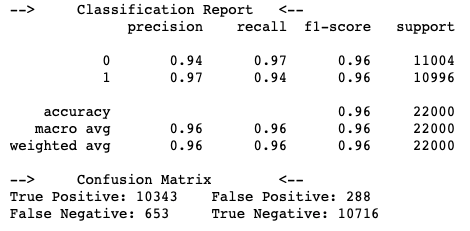

Baseline: 50%

Improvements from baseline: 46%